In [17]:
import pandas as pd 

df = pd.read_csv("roommates_occupancy.csv")

df.head()


,timestamp,room,zone,occupancy
0,2025-01-01 00:00,Bedroom1,1,1
1,2025-01-01 00:00,Bedroom2,2,1
2,2025-01-01 00:00,Bedroom3,2,1
3,2025-01-01 00:00,Bedroom4,2,1
4,2025-01-01 00:00,Bedroom5,3,1


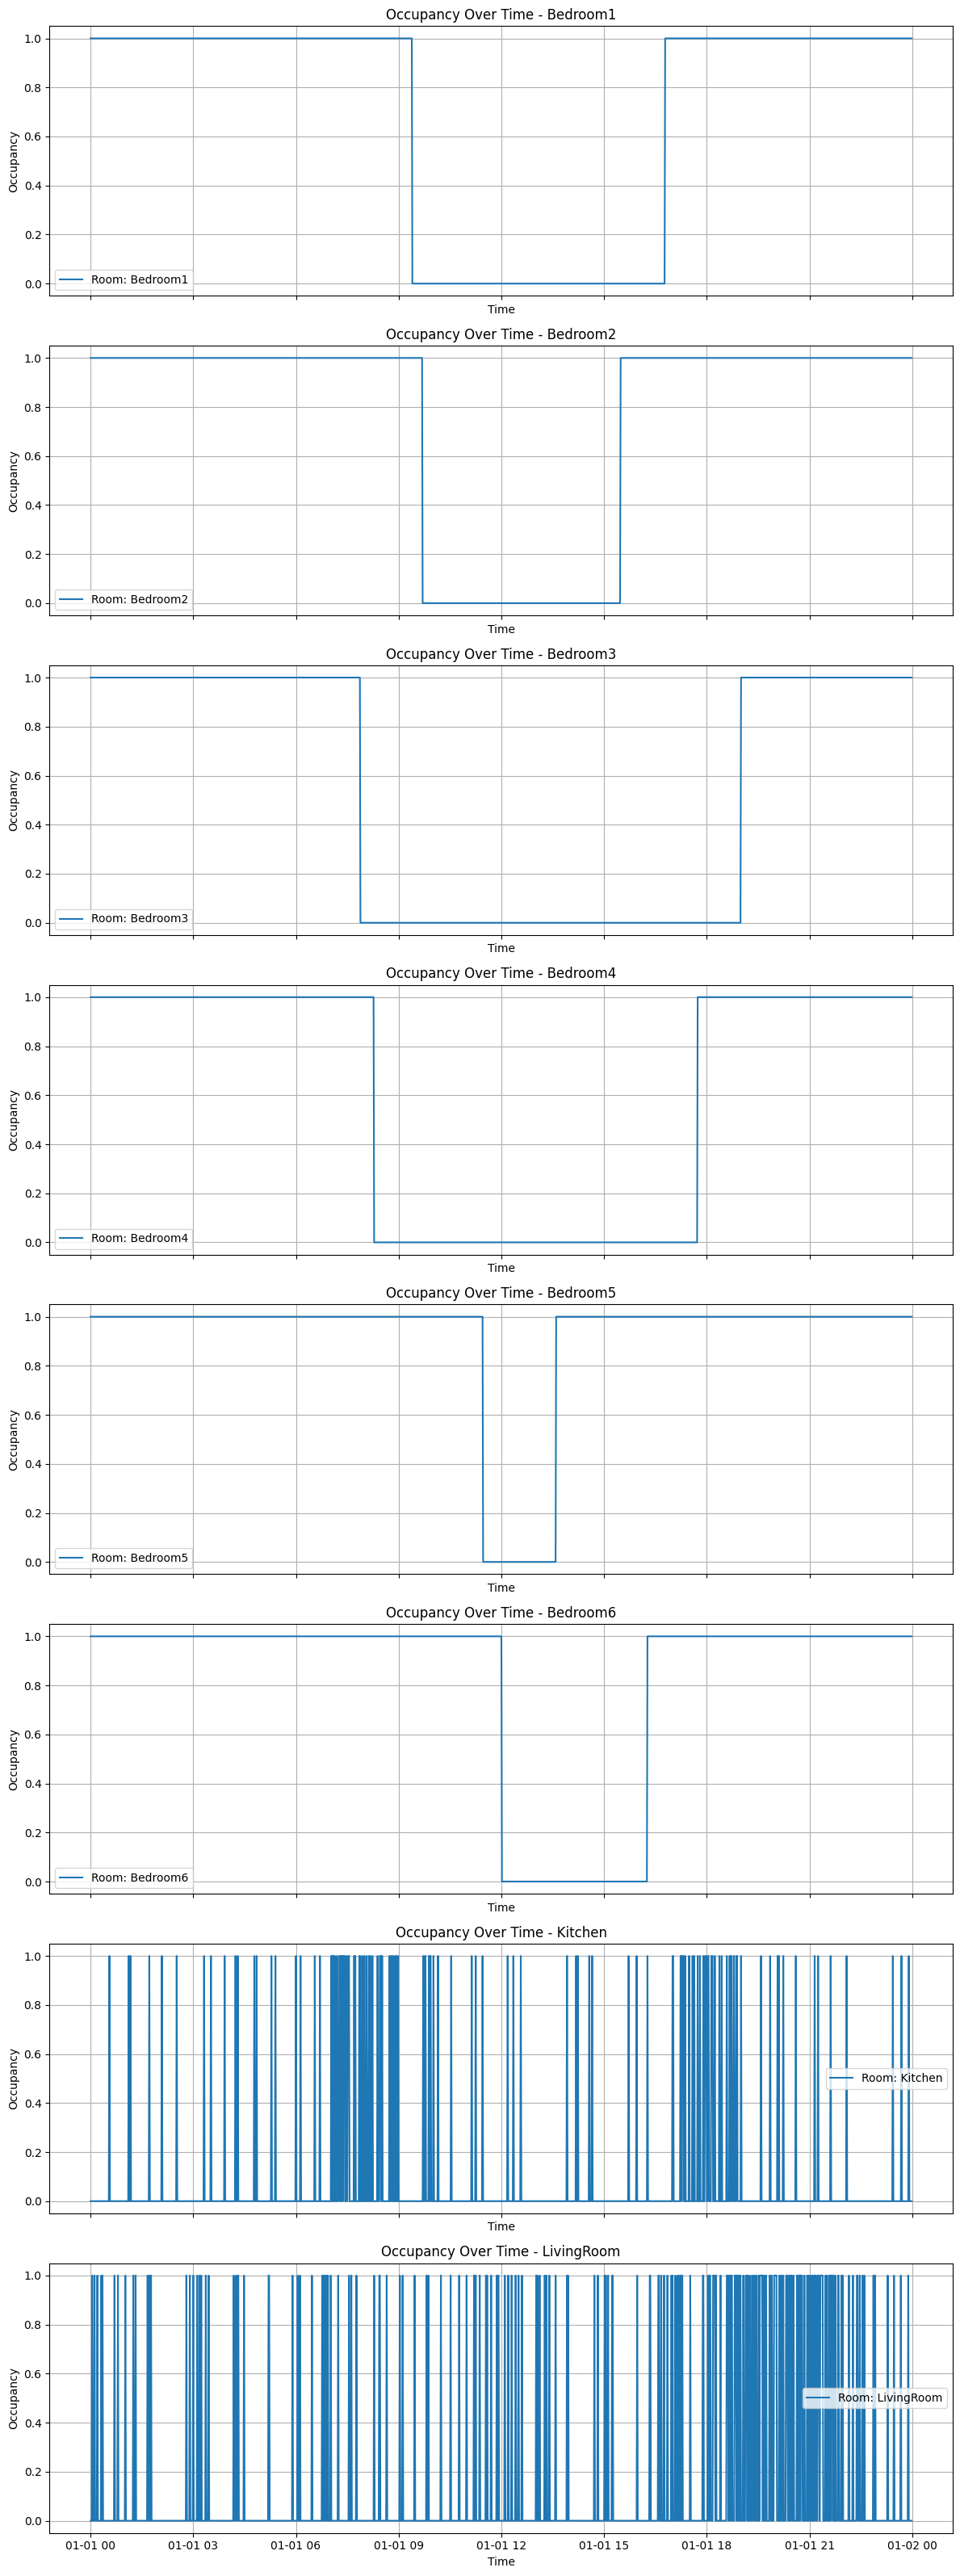

In [18]:
import matplotlib.pyplot as plt

# Ensure the timestamp column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Filter data for the first day
first_day = df['timestamp'].dt.date.min()
df_first_day = df[df['timestamp'].dt.date == first_day]

# Get a list of unique rooms
rooms = df_first_day['room'].unique()

# Create subplots for each room
num_rooms = len(rooms)
fig, axes = plt.subplots(num_rooms, 1, figsize=(12, 4 * num_rooms), sharex=True)

for i, room in enumerate(rooms):
    room_data = df_first_day[df_first_day['room'] == room]
    axes[i].plot(room_data['timestamp'], room_data['occupancy'], label=f"Room: {room}")
    axes[i].set_title(f"Occupancy Over Time - {room}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Occupancy")
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()